# 네이버 영화리뷰 감성분석을 해보자!!

## 고려해야 할 사항
프로젝트 진행 순서는 다음과 같습니다.   
##### 1) 데이터 준비와 확인  

##### 2) 데이터로더 구성  
실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면    
숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다.    
그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다.    
이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다.   
data_loader 안에서는 다음을 수행해야 합니다.   

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

##### 3) 모델구성을 위한 데이터 분석 및 가공  
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

##### 4) 모델구성 및 validation set 구성
- 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

##### 5) 모델 훈련 개시  

##### 6) Loss, Accuracy 그래프 시각화  

##### 7) 학습된 Embedding 레이어 분석   

##### 8) 한국어 Word2Vec 임베딩 활용하여 성능개선   
한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.

https://github.com/Kyubyong/wordvectors

In [1]:
# 1) 데이터 준비와 확인

# 패키지 설치 // 아마도 이거를 고려하면서 코드를 짜면 되지 않을까?!
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

display(train_data.head(3))
display(test_data.head(3))


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0


In [2]:
# 2) 데이터로더 구성

from konlpy.tag import Mecab
tokenizer = Mecab() # 토크나이저는 메캅!! 메칸더 메칸더 메칸더 브이

# 불용어 선언 / 조사와 용언 등
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 일단 데이터를 불러온 다음에 토크나이징을 해야지!! 우선 불러와봅시다!!
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # document라는 컬럼에서 동일한 것을 제거하는 함수 / 변경사항 적용
    train_data = train_data.dropna(how = 'any') # how=any 는 결측치가 하나라도 존재하면 삭제한다는 의미이다.
    test_data.drop_duplicates(subset=['document'], inplace=True) # document라는 컬럼에서 동일한 것을 제거하는 함수 / 변경사항 적용
    test_data = test_data.dropna(how = 'any') # how=any 는 결측치가 하나라도 존재하면 삭제한다는 의미이다.

    # X의 훈련 데이터에는 어떤 것이 들어갈까요
    X_train = []
    for sentence in train_data['document']: # document라는 곳에서 꺼낸당!
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    # X의 테스트 데이터에는 어떤 것이 들어갈까요
    X_test = []
    for sentence in test_data['document']:# document라는 곳에서 꺼낸당!
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨   긍정 :1 / 부정 : 0
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [3]:
# 3) 모델구성을 위한 데이터 분석 및 가공

### 적절한 최대 문장 길이를 알아봅시다. 
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

print("==================================================")

### 패딩추가 !
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 
(146182, 41)


In [4]:
# 4) 모델구성 및 validation set 구성

# 두번째 
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________
(136182, 41)
(136182,)


In [6]:
# 5) 모델 훈련 개시  

# complie
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 학습
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

model.fit(X_train,y_train,epochs=epochs)

result = model.evaluate(X_test,  y_test, verbose=2)
print(result)

Epoch 1/10
4569/4569 [==============================] - 15s 3ms/step - loss: 0.4025 - accuracy: 0.8171
Epoch 2/10
4569/4569 [==============================] - 15s 3ms/step - loss: 0.3230 - accuracy: 0.8615
Epoch 3/10
4569/4569 [==============================] - 16s 3ms/step - loss: 0.2974 - accuracy: 0.8753
Epoch 4/10
4569/4569 [==============================] - 16s 3ms/step - loss: 0.2798 - accuracy: 0.8834
Epoch 5/10
4569/4569 [==============================] - 15s 3ms/step - loss: 0.2664 - accuracy: 0.8907
Epoch 6/10
4569/4569 [==============================] - 15s 3ms/step - loss: 0.2555 - accuracy: 0.8957
Epoch 7/10
4569/4569 [==============================] - 16s 3ms/step - loss: 0.2464 - accuracy: 0.8994
Epoch 8/10
4569/4569 [==============================] - 16s 3ms/step - loss: 0.2388 - accuracy: 0.9030
Epoch 9/10
4569/4569 [==============================] - 15s 3ms/step - loss: 0.2319 - accuracy: 0.9066
Epoch 10/10
4569/4569 [==============================] - 17s 4ms/step - l

Epoch 1/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2030 - accuracy: 0.9218 - val_loss: 0.1917 - val_accuracy: 0.9266
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1988 - accuracy: 0.9236 - val_loss: 0.1935 - val_accuracy: 0.9254
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1958 - accuracy: 0.9248 - val_loss: 0.1959 - val_accuracy: 0.9238
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1933 - accuracy: 0.9260 - val_loss: 0.1990 - val_accuracy: 0.9228
Epoch 5/10
266/266 [==============================] - 1s 6ms/step - loss: 0.1912 - accuracy: 0.9270 - val_loss: 0.2023 - val_accuracy: 0.9218
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1892 - accuracy: 0.9280 - val_loss: 0.2059 - val_accuracy: 0.9190
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1873 - accuracy: 0.9291 - val_loss: 0.2104 - val_accuracy: 0.9163
Epoch 

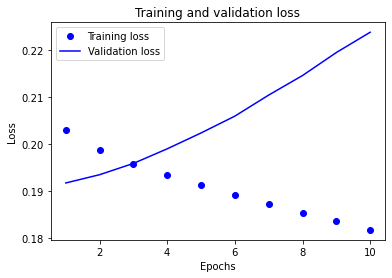

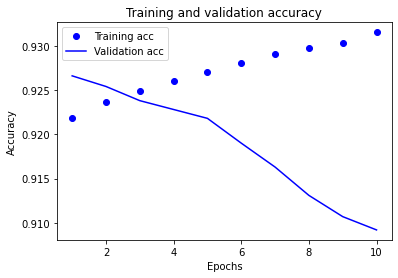

In [7]:
# 6) Loss, Accuracy 그래프 시각화  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들


# loss 를 그려보자
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# accuracy 를 그려보자
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


## 뭐지???? 심각하게 잘못됐는데???
# 왜 훈련 loss는 떨어지고 교차검증 loss는 올라가냐...?

In [ ]:
# 7) 학습된 Embedding 레이어 분석 

In [ ]:
# 8) 한국어 Word2Vec 임베딩 활용하여 성능개선   